# TINT Demonstration


This notebook will take you through the following process:

1. GET DATA - Obtain nexrad data from Amazon S3
2. GRID - Map data to cartesian grids using Py-ART
3. TRACK - Perform cell tracking using TINT
4. VISUALIZE - Visualize the tracks

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Image, display
from matplotlib.animation import FuncAnimation, PillowWriter
import tempfile
import os
import shutil
import pyart
from tint.data_utils import get_nexrad_keys, read_nexrad_key
from tint import Cell_tracks, animate
from tint.visualization import embed_mp4_as_gif


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## 1. GET DATA


In [19]:
day = '01/'
path = '/Users/phucdang/Documents/dangnguyen/Document/project/titan/Data/'

In [20]:
def myFunc(e):
    return e.split('.')[0]

In [60]:
# Let's get some nexrad data from Amazon S3 to use for tracking
# I know of some storm cells that passed over Houston back in July of 2015
# keys = get_nexrad_keys('khgx', start='20150710_183000', end='20150710_193000')
firstDir = path + day + '1_prt/'

keys = [firstDir + fileName for fileName in os.listdir(firstDir)]
keys.sort(key=myFunc)
keys[:10]

['/Users/phucdang/Documents/dangnguyen/Document/project/titan/Data/01/1_prt/NHB230601000008.RAWLGZV',
 '/Users/phucdang/Documents/dangnguyen/Document/project/titan/Data/01/1_prt/NHB230601001008.RAWLH02',
 '/Users/phucdang/Documents/dangnguyen/Document/project/titan/Data/01/1_prt/NHB230601002007.RAWLH09',
 '/Users/phucdang/Documents/dangnguyen/Document/project/titan/Data/01/1_prt/NHB230601003007.RAWLH0G',
 '/Users/phucdang/Documents/dangnguyen/Document/project/titan/Data/01/1_prt/NHB230601004008.RAWLH0P',
 '/Users/phucdang/Documents/dangnguyen/Document/project/titan/Data/01/1_prt/NHB230601005008.RAWLH0X',
 '/Users/phucdang/Documents/dangnguyen/Document/project/titan/Data/01/1_prt/NHB230601010007.RAWLH14',
 '/Users/phucdang/Documents/dangnguyen/Document/project/titan/Data/01/1_prt/NHB230601011008.RAWLH1B',
 '/Users/phucdang/Documents/dangnguyen/Document/project/titan/Data/01/1_prt/NHB230601012008.RAWLH1J',
 '/Users/phucdang/Documents/dangnguyen/Document/project/titan/Data/01/1_prt/NHB230

ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.3 (clang-1403.0.22.14.1)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/6.0_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disab

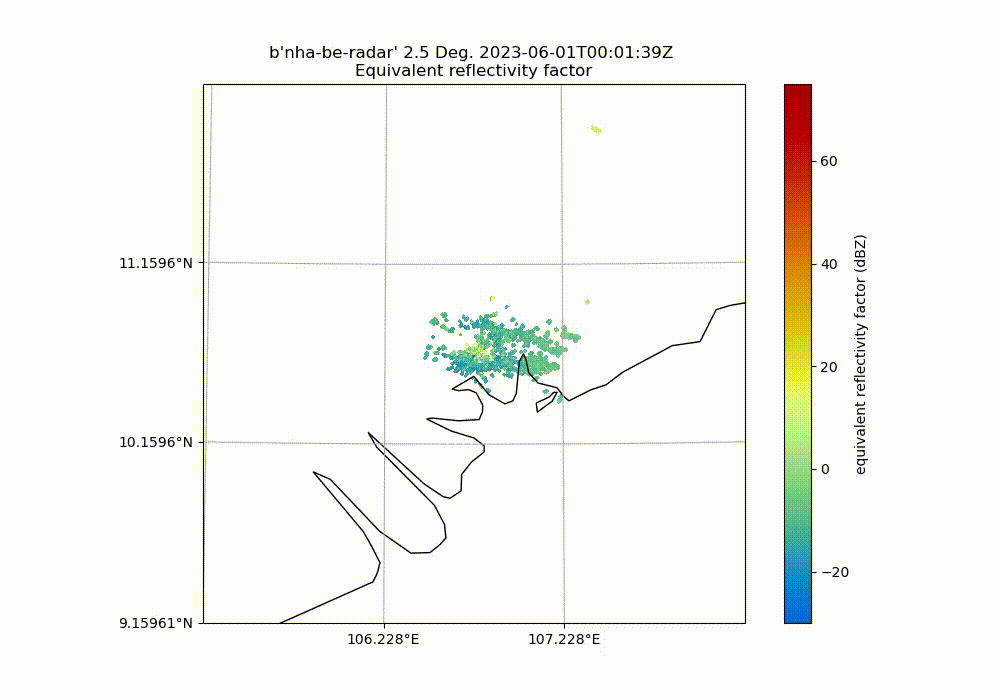

In [104]:
# We can visualize this data using pyart and matplotlib
fig = plt.figure(figsize=(10, 7))


def plot_ppi(key):
    """ Plots ppi map of nexrad data given S3 key. """
    plt.clf()
    radar = pyart.io.read(key)
    display = pyart.graph.RadarMapDisplay(radar)
    display.plot_ppi_map(   'reflectivity', 
                        resolution='50m',
                        sweep=2, 
                        fig=fig,
                        lat_lines=np.arange(radar.latitude['data'][0]-1.5, radar.latitude['data'][0]+1.5, 1),
                        lon_lines=np.arange(radar.longitude['data'][0]-1.5, radar.longitude['data'][0]+1.5, 1),
                        min_lon=radar.longitude['data'][0]-1.5, 
                        max_lon=radar.longitude['data'][0]+1.5, 
                        min_lat=radar.latitude['data'][0]-1.5, 
                        max_lat=radar.latitude['data'][0]+1.5,
                        lon_0=radar.longitude['data'][0],
                        lat_0=radar.latitude['data'][0]
                        )
    del display, radar


ppi_anim = FuncAnimation(fig, plot_ppi, frames=keys[:10], interval=500)
tmp_anim = tempfile.NamedTemporaryFile()
ppi_anim.save(tmp_anim.name + '.mp4', writer='ffmpeg')
embed_mp4_as_gif(tmp_anim.name + '.mp4')
os.remove(tmp_anim.name + '.mp4')
plt.close()

## 2. GRID

### Disclaimer
If you are running this notebook and don't want this data to remain on your filesystem, make sure you run the last cell in the notebook. If your kernel crashes for some reason, you can manually remove the the path printed after the following cell.

In [124]:
# Looks like there are some interesting cells coming off the gulf.
# Let's make a function that maps these volumes to cartesian grids using pyart.
# Most of the cells seem to be in the bottom right quadrant, so we'll only grid
# that part of the domain to save time.

def get_grid(radar):
    """ Returns grid object from radar object. """
    grid = pyart.map.grid_from_radars(
        radar, grid_shape=(31, 401, 401),
        grid_limits=((0, 15000), (0,100000), (0, 130000)),
        fields=['reflectivity'], gridding_algo='map_gates_to_grid',
        h_factor=0., nb=0.6, bsp=1., min_radius=200.)
    return grid


# Let's write these grids to a temporary location so that we can reuse them.
# This might take a few minutes
tmp_dir = tempfile.mkdtemp()
print('temporary directory:', tmp_dir)
filenames = []
for num, key in enumerate(keys[:10]):
    print('saving grid', num)
    radar = pyart.io.read(key)
    grid = get_grid(radar)
    name = os.path.join(tmp_dir, 'grid_' + str(num).zfill(3) + '.nc')
    filenames.append(name)
    pyart.io.write_grid(name, grid)
    del radar, grid

temporary directory: /var/folders/97/qq731g4565sbxx06ghqh1ryr0000gn/T/tmppp9y5jjc
saving grid 0
saving grid 1
saving grid 2
saving grid 3
saving grid 4
saving grid 5
saving grid 6
saving grid 7
saving grid 8
saving grid 9


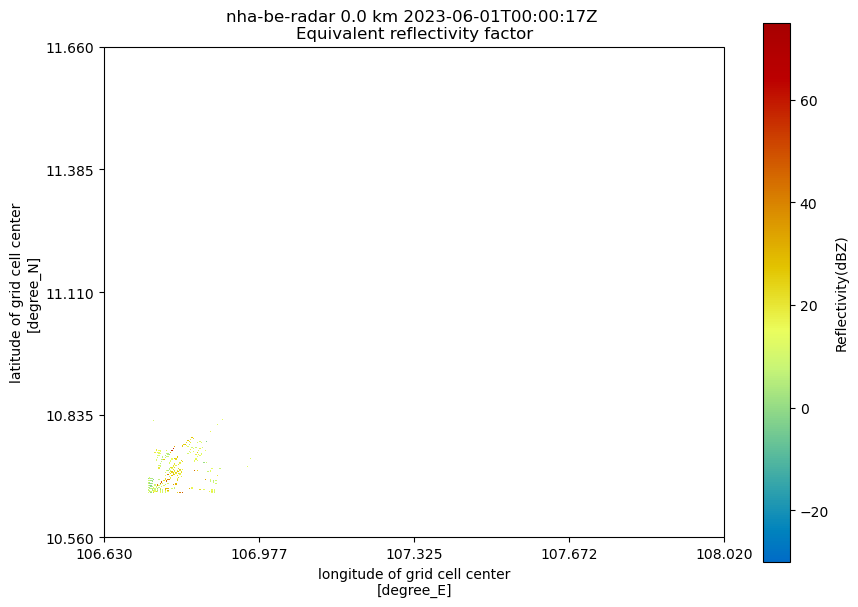

In [125]:
fig = plt.figure(figsize=(10, 7))

plt.clf()
# grid = pyart.io.read_grid_mdv('/Users/phucdang/Desktop/titan/20230601/20230601_000259.mdv')
grid = pyart.io.read_grid(tmp_dir + "/grid_000.nc")
display = pyart.graph.GridMapDisplay(grid)
display.plot_grid('reflectivity',
                        fig=fig)



# Save to /Users/phucdang/Desktop/titan/grid.png
# plt.axis('off')
del display, grid

In [126]:
# Now we can easily instantiate generators of these grids like so
grids = (pyart.io.read_grid(fn) for fn in filenames)

## 3. TRACK

In [127]:
# First, let's instantiate a tracks object and view the default parameters
tracks_obj = Cell_tracks()
tracks_obj.params

{'FIELD_THRESH': 32,
 'MIN_SIZE': 8,
 'SEARCH_MARGIN': 4000,
 'FLOW_MARGIN': 10000,
 'MAX_FLOW_MAG': 50,
 'MAX_DISPARITY': 999,
 'MAX_SHIFT_DISP': 15,
 'ISO_THRESH': 8,
 'ISO_SMOOTH': 3,
 'GS_ALT': 1500}

In [128]:
# The cells we're interested in look a bit small. Let's reduce the minimum size threshold.
tracks_obj.params['MIN_SIZE'] = 4
# We'll give the generator of grids we made earlier to the get_tracks method of our tracks object.
tracks_obj.get_tracks(grids)

Writing tracks for scan 0
No cells found in scan 1
Writing tracks for scan 2
Writing tracks for scan 3
Writing tracks for scan 4
Writing tracks for scan 5
Writing tracks for scan 6
Writing tracks for scan 7
Writing tracks for scan 8
Writing tracks for scan 9


time elapsed 0.1 minutes


In [129]:
# Now we can view the 'tracks' attribute of our tracks object to see the results.
tracks_obj.tracks.head(2)

,,time,grid_x,grid_y,lon,lat,area,vol,max,max_alt,isolated
scan,uid,,,,,,,,,,
0,0,2023-06-01 00:00:17,356.789,299.423,107.7925,11.3300,5.76875,11.375000,40.600002,3.5,True
2,1,2023-06-01 00:20:36,373.712,197.916,107.8423,11.1028,23.15625,49.521875,42.049999,3.5,False


## 4. VISUALIZE

In [130]:
# We can visualize these tracks to assess the performance of the algorithm.
# First we need to make another generator of the same grids for the animator
grids = (pyart.io.read_grid(fn) for fn in filenames)

In [131]:
radar = pyart.io.read(keys[0])

In [134]:
# Let's save the animation in our temp directory so that it will be cleaned up later.
animate(tracks_obj, grids, os.path.join(tmp_dir, 'tint_demo_animate'),
        lat_lines=np.arange(radar.latitude['data'][0], radar.latitude['data'][0]+1.5, 0.3),
        lon_lines=np.arange(radar.longitude['data'][0], radar.longitude['data'][0]+1.5, 0.3),
        tracers=True)

Animating 10 frames
Frame: 0
Frame: 1
Frame: 2
Frame: 3
Frame: 4
Frame: 5
Frame: 6
Frame: 7
Frame: 8
Frame: 9


ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.3 (clang-1403.0.22.14.1)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/6.0_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disab

ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.3 (clang-1403.0.22.14.1)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/6.0_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disab

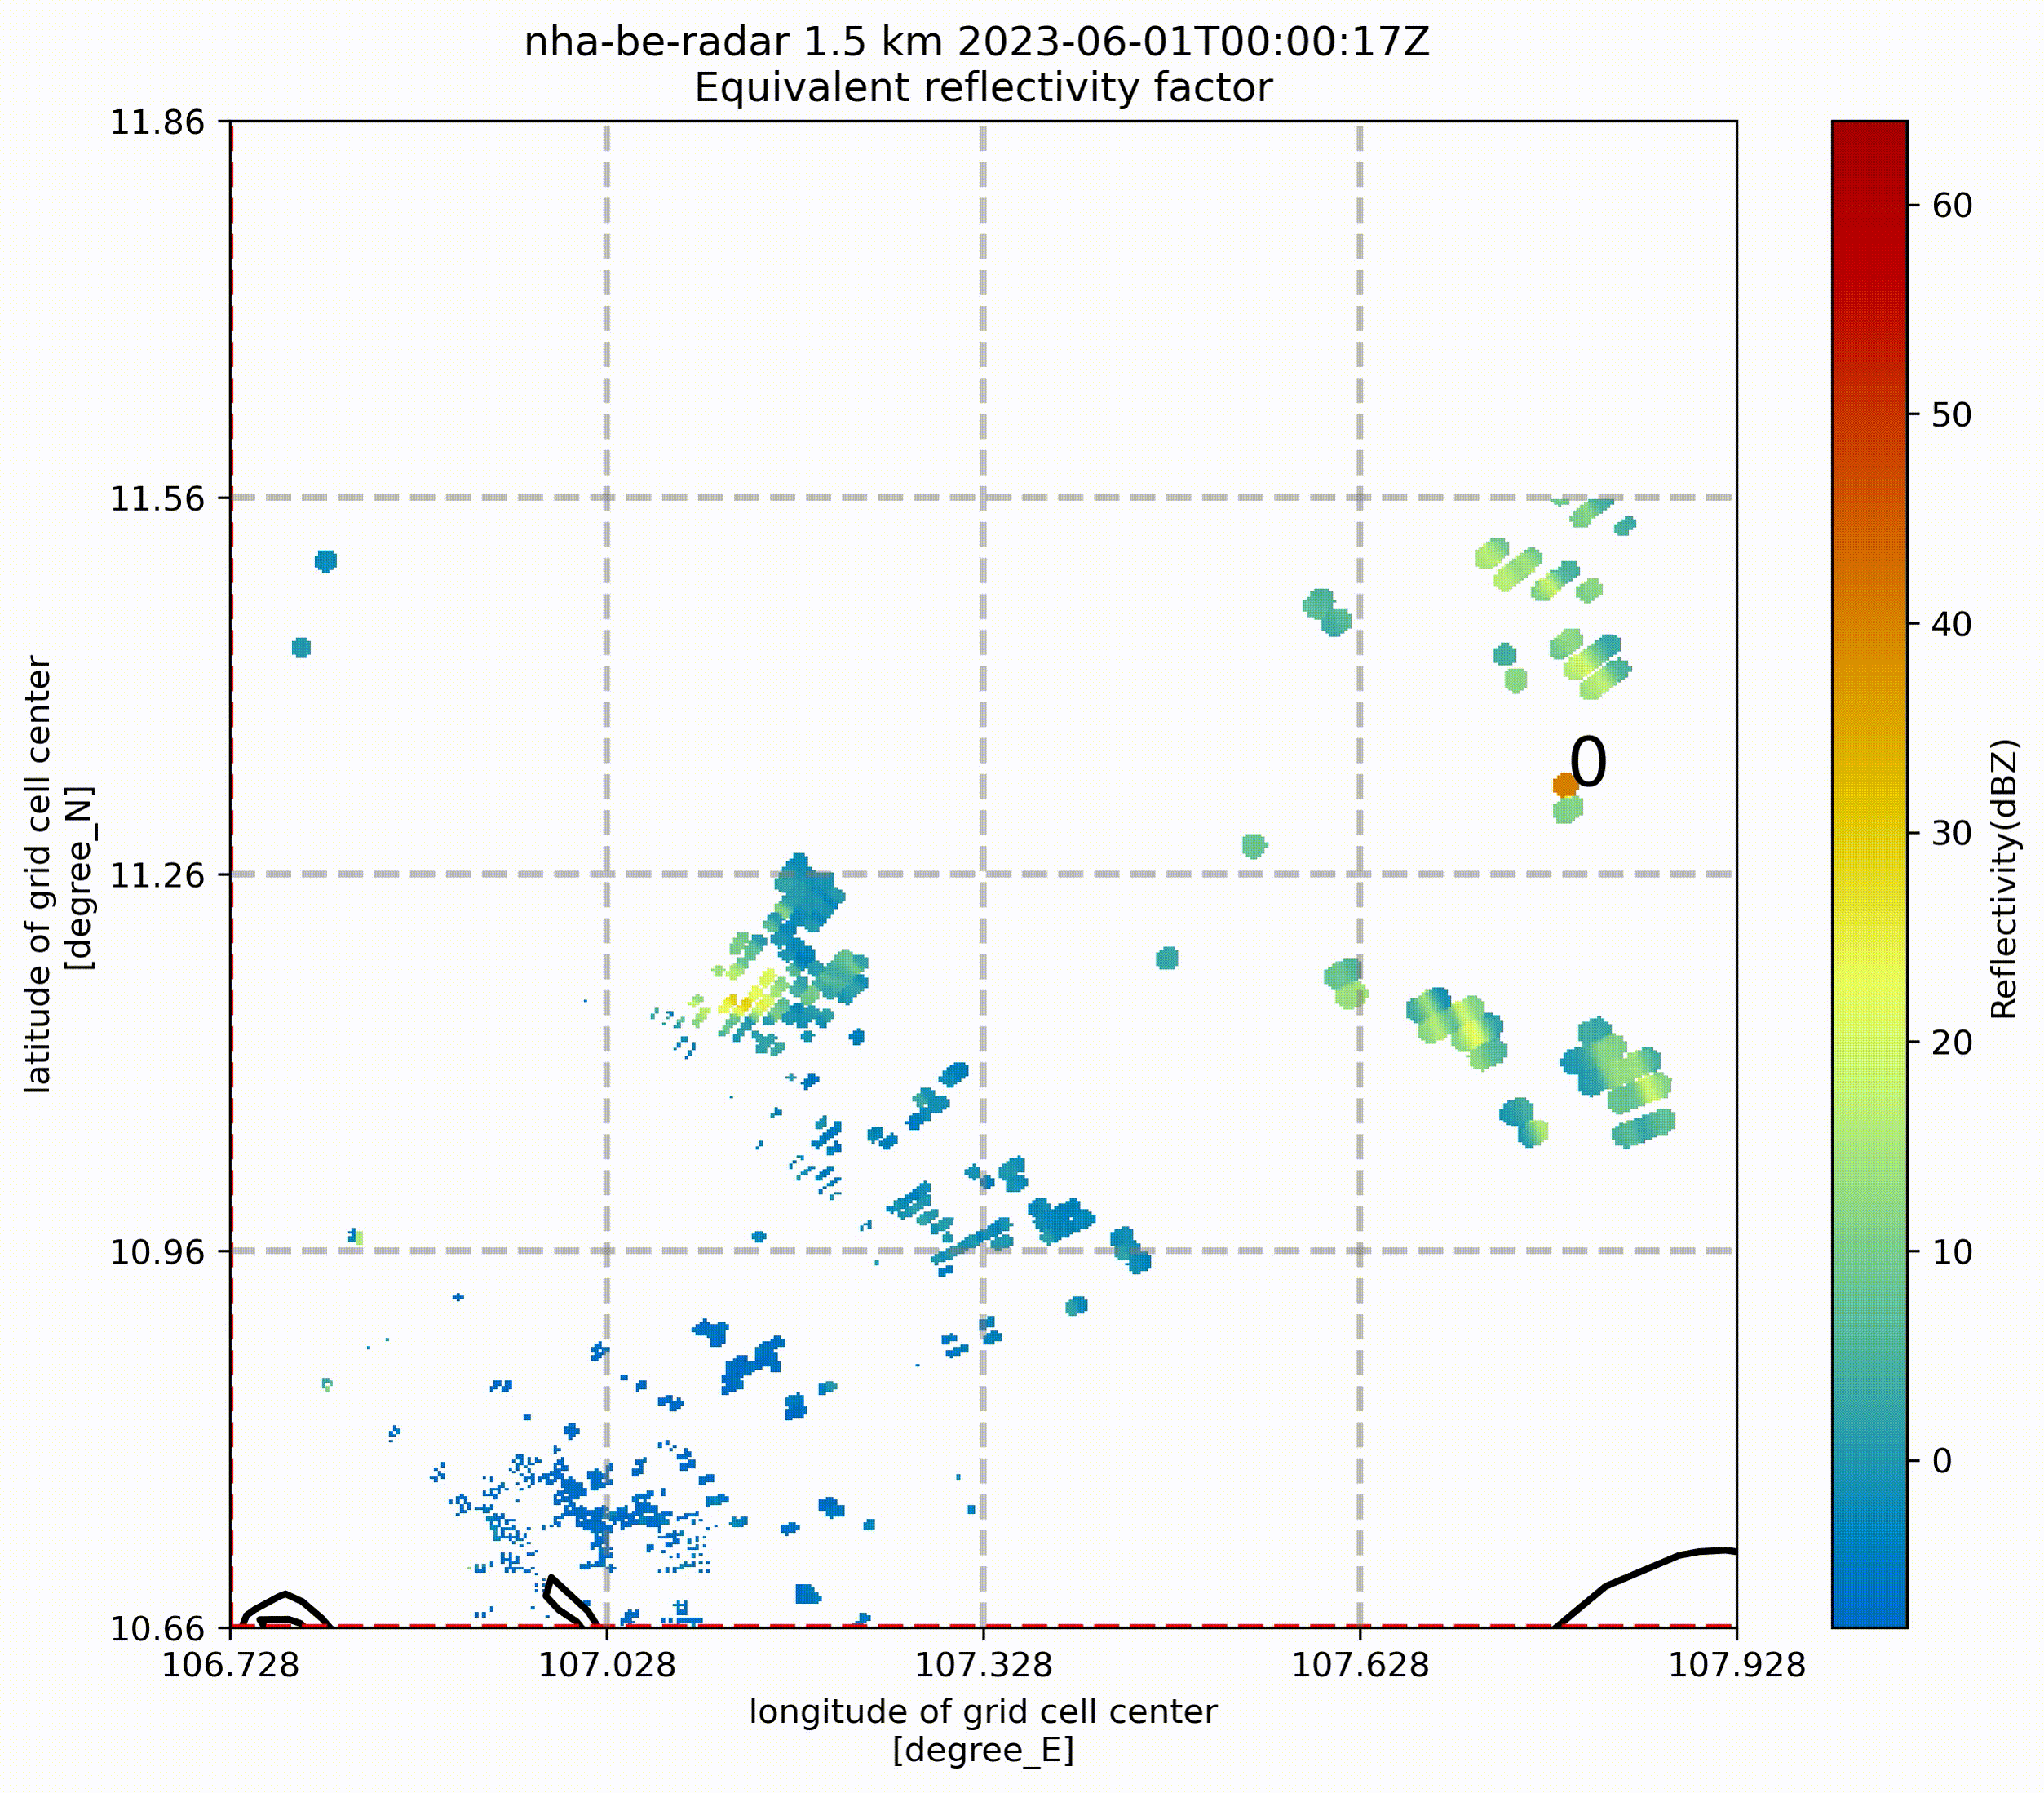

In [135]:
# The animator saved an mp4 to our local directory. Now we can embed it as a gif in this notebook.
embed_mp4_as_gif(os.path.join(tmp_dir, 'tint_demo_animate.mp4'))

In [136]:
# Let's find the cells that were tracked for the most frames
tracks_obj.tracks.groupby(level='uid').size().sort_values(ascending=False)[:5]

uid
9     4
5     3
8     2
12    2
13    2
dtype: int64

In [137]:
# Now we can view these cells from a lagrangian perspective
grids = (pyart.io.read_grid(fn) for fn in filenames)  # refresh grid generator
animate(tracks_obj, grids, os.path.join(tmp_dir, 'tint_demo_lagrangian'), style='lagrangian', uid='0', alt=2000)

Animating 1 frames
Frame: 0


ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.3 (clang-1403.0.22.14.1)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/6.0_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disab

ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.3 (clang-1403.0.22.14.1)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/6.0_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disab

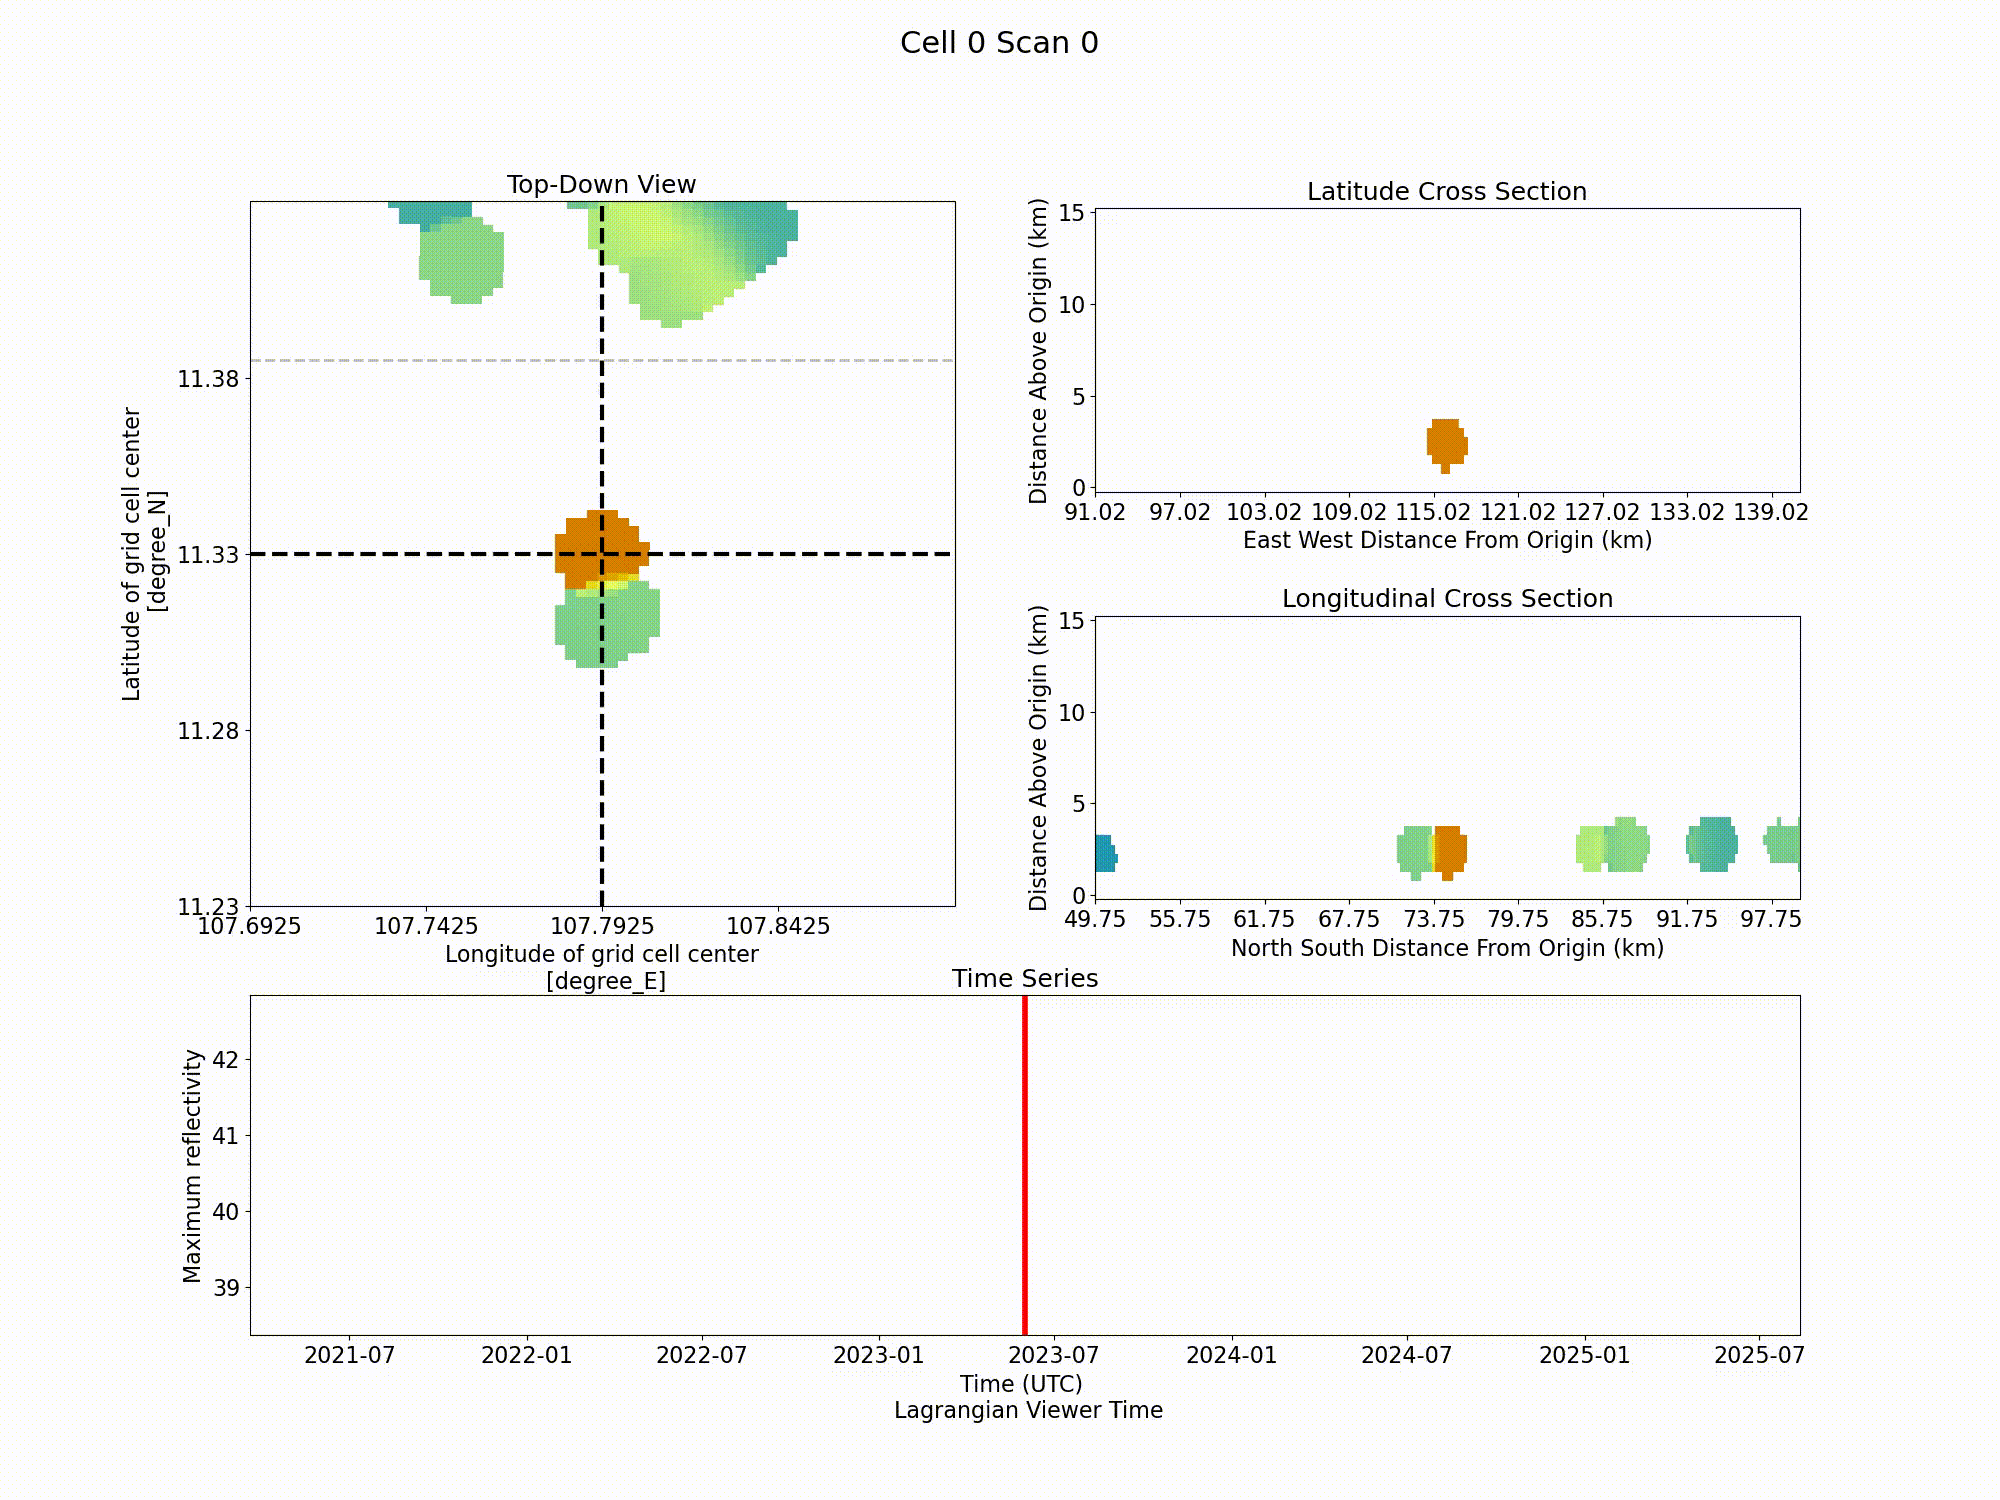

In [138]:
embed_mp4_as_gif(os.path.join(tmp_dir, 'tint_demo_lagrangian.mp4'))

In [139]:
# We can view the attributes of this cell throughout its lifetime
tracks_obj.tracks.xs('0', level='uid')

,time,grid_x,grid_y,lon,lat,area,vol,max,max_alt,isolated
scan,,,,,,,,,,
0,2023-06-01 00:00:17,356.789,299.423,107.7925,11.33,5.76875,11.375,40.600002,3.5,True


## Clean Up

In [140]:
# Now we can delete the directory containing all the data and output from this demo.
shutil.rmtree(tmp_dir)
print('temporary directory removed')

temporary directory removed
